In [1]:
# ruff: noqa: N802, N803, N806, N815, N816
import os

import matplotlib.pyplot as plt
import numpy as np
from scipy import signal

import archimedes as arc
from archimedes.docs.utils import display_text, extract_c_function

THEME = os.environ.get("ARCHIMEDES_THEME", "dark")
arc.theme.set_theme(THEME)

# Generating C code

The first step on the road to deployment is understanding the process of translating your Python logic into C code.

## Python implementation

First, let's write our Python function.  In this example we'll be working with an "infinite impulse response" (IIR) filter in the form of a difference equation:

$$
y_n = \sum_{i=0}^{N_n} b_i u_{n-i} - \sum_{i=1}^{N_d} a_i y_{n-i}
$$

In short, an IIR filter is a type of digital filter where the current output depends on both current and past inputs *and* past outputs.
This "feedback" property gives IIR filters powerful frequency response characteristics with relatively few coefficients, making them efficient for embedded systems.

The idea is that we can use Python ecosystem tools like `scipy.signal` for filter design and testing on reference signals, and then quickly deploy updated filters to a microcontroller.

Here's a basic implementation of the IIR difference equation:

In [2]:
@arc.compile(return_names=("u_hist", "y_hist"))
def iir_filter(u, b, a, u_prev, y_prev):
    # Update input history
    u_prev[1:] = u_prev[:-1]
    u_prev[0] = u

    # Compute output using the direct II transposed structure
    y = (np.dot(b, u_prev) - np.dot(a[1:], y_prev[: len(a) - 1])) / a[0]

    # Update output history
    y_prev[1:] = y_prev[:-1]
    y_prev[0] = y

    return u_prev, y_prev

There are a couple of things to note about this implementation.

- It does not hardcode any values for the length of the arrays (filter order)
- It is "functionally pure", meaning that all outputs are direct functions of the inputs
- The `@compile` decorator needs to know names of the return values (and these must be different from any argument names)

**Functional purity** is crucial for code generation. In a pure function:
- The same inputs always produce the same outputs
- No "side effects" occur (like modifying global variables or external state)
- All data transformations are explicitly captured in the inputs and outputs

This property allows Archimedes to correctly trace the computational flow and generate equivalent C code without unexpected behaviors.
State changes that could otherwise be handled via side effects in imperative code must be explicitly returned as outputs and fed back as inputs in subsequent calls.

Writing it to be general regardless of array length means we can experiment with different filter orders without rewriting any C code.  The pure form allows the function to be traced symbolically (since there are no side effects) and also means the function mimics the logic that the C code will follow in order to pre-allocate all memory.  

This is an important potentially counterintuitive point; typically when optimizing pure NumPy code you might pre-allocate "buffer" arrays to avoid as much dynamic memory allocation as possible.  With Archimedes, you do not need to (and in fact cannot) do this.  Instead, the code generation system determines memory handling for you.  We'll see what this looks like shortly.  This helps to separate the mathematical logic of a function from its implementation details.

Next we can use SciPy's tools to design filter coefficients:

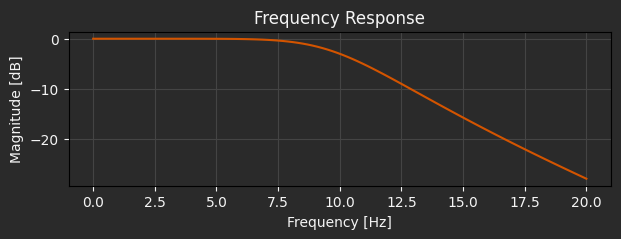

In [3]:
dt = 0.01  # Sampling time [seconds]
Wn = 10  # Cutoff frequency [Hz]
order = 4
b, a = signal.butter(order, Wn, "low", analog=False, fs=1 / dt)

# Plot the frequency response
w = np.linspace(0, 2 * Wn, 100)
_, h = signal.freqz(b, a, worN=w, fs=1 / dt)
plt.figure(figsize=(7, 2))
plt.plot(w, 20 * np.log10(abs(h)))
plt.xlabel("Frequency [Hz]")
plt.ylabel("Magnitude [dB]")
plt.title("Frequency Response")
plt.grid()
plt.show()

Before proceeding with code generation, it is wise to check that the Python function does what it is intended to.  In this case we can compare the step response as calculated by `iir_filter` to the one calculated by `scipy.signal.lfilter`.  If these match, we can be confident that our code is working properly.  More generally, you might want to implement some simulation code and a set of unit tests to comprehensively test your Python code before converting to C.

Step response matches: True


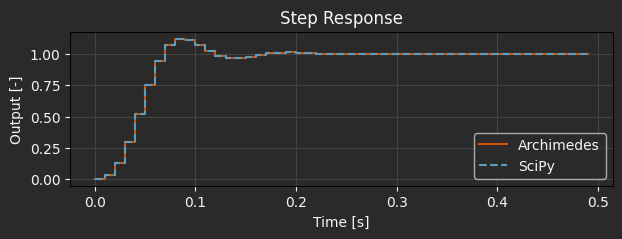

In [4]:
# Apply the IIR filter to a step input
u = np.ones(50)
t = np.arange(len(u)) * dt

u_prev = np.zeros(len(b))
y_prev = np.zeros(len(a) - 1)
y = np.zeros_like(u)
for i in range(len(y)):
    u_prev, y_prev = iir_filter(u[i], b, a, u_prev, y_prev)
    y[i] = y_prev[0]

# SciPy filter function
y_sp = signal.lfilter(b, a, u)
print("Step response matches:", np.allclose(y, y_sp))

plt.figure(figsize=(7, 2))
plt.step(t, y, label="Archimedes", where="post")
plt.step(t, y_sp, "--", label="SciPy", where="post")
plt.grid()
plt.xlabel("Time [s]")
plt.ylabel("Output [-]")
plt.title("Step Response")
plt.legend()
plt.show()

## Converting to C code

Once we've written a symbolically-compiled Python function, it's easy to generate corresponding C code using the [`codegen`](#archimedes.codegen) function.
Besides the function to generate code for and the target filename (with a ".c" extension), `codegen` requires "template" arguments that are used to determine the size of all inputs, outputs, and intermediate results in the function.
When translating the Python to C code as in this example, the actual values of these template arguments aren't used.
In the next part of the tutorial we'll see where the values come in.

There are a number of other options that can be used to configure the generated code, such as:

- The data type used for floating-point numbers (defaults to "float")
- The data type used for integers (defaults to "long int")
- Whether to generate C or C++ code (default: C)
- The number of spaces used for indentation of the generated code (default: 4)

See the [documentation](#archimedes.codegen) for more details on how to configure code generation.

Note that in CasADi symbolics, _everything is a float_.
This means that generated code will have all arguments and returns as float types (though you can specify which float type to use).
Integers are used internally as counters, flags, etc. but cannot be used as inputs and outputs.

In [5]:
# Create "template" arguments for type inference
u = 1.0
u_prev = np.zeros(len(b))
y_prev = np.zeros(len(a) - 1)
args = (u, b, a, u_prev, y_prev)

arc.codegen(iir_filter, args)

This will generate four files: the C code implementation `iir_filter_kernel.c` and a corresponding header file `iir_filter_kernel.h`, and the API interface layer `iir_filter.c` and `iir_filter.h`.
We'll get to the API in the next section, but it's worth taking a look at the "kernel" code as well.

The parts of the generated code that are intended to be used directly are enumerated in the header file - let's take a look.

In [6]:
with open("iir_filter_kernel.h", "r") as f:
    c_code = f.read()

display_text(c_code)

```c
/* This file was automatically generated by CasADi 3.7.0.
 *  It consists of: 
 *   1) content generated by CasADi runtime: not copyrighted
 *   2) template code copied from CasADi source: permissively licensed (MIT-0)
 *   3) user code: owned by the user
 *
 */
#ifdef __cplusplus
extern "C" {
#endif

#ifndef casadi_real
#define casadi_real float
#endif

#ifndef casadi_int
#define casadi_int long int
#endif

int iir_filter(const casadi_real** arg, casadi_real** res, casadi_int* iw, casadi_real* w, int mem);
int iir_filter_alloc_mem(void);
int iir_filter_init_mem(int mem);
void iir_filter_free_mem(int mem);
int iir_filter_checkout(void);
void iir_filter_release(int mem);
void iir_filter_incref(void);
void iir_filter_decref(void);
casadi_int iir_filter_n_in(void);
casadi_int iir_filter_n_out(void);
casadi_real iir_filter_default_in(casadi_int i);
const char* iir_filter_name_in(casadi_int i);
const char* iir_filter_name_out(casadi_int i);
const casadi_int* iir_filter_sparsity_in(casadi_int i);
const casadi_int* iir_filter_sparsity_out(casadi_int i);
int iir_filter_work(casadi_int *sz_arg, casadi_int* sz_res, casadi_int *sz_iw, casadi_int *sz_w);
int iir_filter_work_bytes(casadi_int *sz_arg, casadi_int* sz_res, casadi_int *sz_iw, casadi_int *sz_w);
#define iir_filter_SZ_ARG 7
#define iir_filter_SZ_RES 3
#define iir_filter_SZ_IW 0
#define iir_filter_SZ_W 27
#ifdef __cplusplus
} /* extern "C" */
#endif

```

As stated at the top of the file, this is auto-generated by the CasADi backend, which converts the C++ computational graph for our `iir_filter` function to efficient C code.

Let's go through two important parts of this file in a little bit of detail.

```c
#ifndef casadi_real
#define casadi_real float
#endif

#ifndef casadi_int
#define casadi_int long int
#endif
```

Here CasADi defines type aliases as determined by the configuration.  It can be helpful to override these on embedded systems with limited precision or memory capacity.

```c
int iir_filter(const casadi_real** arg, casadi_real** res, casadi_int* iw, casadi_real* w, int mem);
```

This is the main function call.  However, unlike the Python version, the arguments, results, and work arrays `iw` and `w` are passed as pointers.
Before we call this function, we have to properly allocate and initialize all of these.  
Much of the rest of the functions are helper routines for setting up this required memory.
However, in our case we will rely on the "interface" layer generated by Archimedes to handle all of this, so ultimately we won't need to work with any of it directly.

We can take a look at the actual `iir_filter` implementation in the `iir_filter_kernel.c` file:

In [7]:
extract_c_function("iir_filter_kernel.c", "iir_filter")
extract_c_function("iir_filter_kernel.c", "casadi_f0")
extract_c_function("iir_filter_kernel.c", "casadi_dot")
extract_c_function("iir_filter_kernel.c", "casadi_copy")

```c
CASADI_SYMBOL_EXPORT int iir_filter(const casadi_real** arg, casadi_real** res, casadi_int* iw, casadi_real* w, int mem){
    return casadi_f0(arg, res, iw, w, mem);
}
```

```c
static int casadi_f0(const casadi_real** arg, casadi_real** res, casadi_int* iw, casadi_real* w, int mem) {
  casadi_real *rr, *w0=w+0, *w1=w+5, w2, *w3=w+10, *w4=w+13, *w5=w+17, *w6=w+22, w7;
  const casadi_real *cs;
    casadi_copy(arg[3], 5, w0);
    for (rr=w1, cs=w0+0; cs!=w0+4; cs+=1) *rr++ = *cs;
    for (rr=w0+1, cs=w1; rr!=w0+5; rr+=1) *rr = *cs++;
    w2 = arg[0] ? arg[0][0] : 0;
    for (rr=w0+0, cs=(&w2); rr!=w0+1; rr+=1) *rr = *cs++;
    casadi_copy(w0, 5, res[0]);
    casadi_copy(arg[4], 4, w1);
    for (rr=w3, cs=w1+0; cs!=w1+3; cs+=1) *rr++ = *cs;
    casadi_copy(w1, 4, w4);
    for (rr=w4+1, cs=w3; rr!=w4+4; rr+=1) *rr = *cs++;
    casadi_copy(arg[1], 5, w5);
    w2 = casadi_dot(5, w5, w0);
    casadi_copy(arg[2], 5, w5);
    for (rr=w6, cs=w5+1; cs!=w5+5; cs+=1) *rr++ = *cs;
    w7 = casadi_dot(4, w6, w1);
    w2 -= w7;
    for (rr=(&w7), cs=w5+0; cs!=w5+1; cs+=1) *rr++ = *cs;
    w2 /= w7;
    for (rr=w4+0, cs=(&w2); rr!=w4+1; rr+=1) *rr = *cs++;
    casadi_copy(w4, 4, res[1]);
    return 0;
}
```

```c
casadi_real casadi_dot(casadi_int n, const casadi_real* x, const casadi_real* y) {
  casadi_int i;
  casadi_real r = 0;
  for (i=0; i<n; ++i) r += *x++ * *y++;
  return r;
}
```

```c
void casadi_copy(const casadi_real* x, casadi_int n, casadi_real* y) {
  casadi_int i;
  if (y) {
    if (x) {
      for (i=0; i<n; ++i) *y++ = *x++;
    } else {
      for (i=0; i<n; ++i) *y++ = 0.;
    }
  }
}
```

A few things to note about this implementation:

* **Static allocation**: The generated code uses pre-allocated workspace memory instead of dynamic memory allocation, meaning no heap usage.

* **Deterministic memory**: Requirements can be precisely calculated at compile time.

* **Fixed-Size Arrays**: All array dimensions are determined at code generation time, ensuring predictable memory usage regardless of input data.

* **No external dependencies**: The generated code is self-contained, simplifying the build process for deployment.

These details are critical for real-time and embedded applications.

However, the price for this efficiency is that the implementation hardly resembles the original Python algorithm, nor is it what you might normally consider to be "human readable".
This is why the automatic code generation paradigm is so helpful; the high-level algorithm can be modified in Python without the need for time-intensive re-coding the low-level C implementation.

However, at this point we still have quite a bit of work ahead of us.
In particular, we still need to:

1. Create arrays for arguments, results, and working memory
2. Map these to the pointers expected by the `iir_filter` implementation
3. Initialize the arrays correctly

If you examine the source code more carefully, you might even be surprised to see that the filter coefficients aren't even stored in the C code.
We could of course use these as global variables in Python, which would effectively "hardcode" the filter coefficients into the generated C code, but it is cleaner and more maintainable to separate the coeffients from the actual filter implementation.

Archimedes handles this with a standardized "interface" layer that makes it easier to work with this kernel code.
In the next part of the tutorial we'll begin to explore this autogenerated API.